In [2]:
import torch
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from IPython.display import clear_output
from tqdm import tqdm


#Import Testing Functions 
from utils import plot_pred_distribution,apply_evaluate
from constraints import apply_process,get_markers_rocket_order_with_constraint

torch.manual_seed(42)
np.random.seed(42)


In [3]:
## Testing Function -- Loop Through Each Well in Testing Data
def run_prediction(mymodel,use_constraint=True,confidence_level=0.96,verbose=0):
    start = time.time()
    intervals = apply_process(df_tops,confidence_level,log=True)
    df_tops_pred = pd.DataFrame(pd.DataFrame(columns = ['wellName','MARCEL', 'SYLVAIN', 'CONRAD']))
    for well in tqdm(df_test_tops.index, desc=f"Processing Wells"):
        pred_m, df_wm = get_markers_rocket_order_with_constraint(well,f_mean, f_std,intervals, df_test_log, pred_column, wsize, input_variable, 
                                             s2s = True,
                                             model = mymodel, 
                                             xgb = False,
                                             rocket = None, 
                                             classifier_xgb = None, 
                                             classifier = None,
                                             constraint = use_constraint)
        if verbose:
            print(well,pred_m)
        row = {'wellName':well, 'MARCEL':pred_m[0], 'SYLVAIN':pred_m[1], 'CONRAD':pred_m[2]}
        row_df = pd.DataFrame([row])
        df_tops_pred = pd.concat([df_tops_pred, row_df], axis = 0, ignore_index = "True")
        
    ext = time.time() - start
    print(f'🍺 Total prediction time {ext}')
    df_tops_pred['wellName']  = df_tops_pred['wellName'].astype(float)
    df_tops_pred = df_tops_pred.sort_values(by = ['wellName']).reset_index().drop(['index'], axis = 1)
    df_tops_pred = df_tops_pred.set_index('wellName')
    return df_tops_pred

### LOAD Traing and Testing Data

In [4]:
#Load Prepared Training Data

X = np.load('prepared_data/X_201.npy')
y= np.load('prepared_data/y_201.npy')

# X = np.load('prepared_data/X_101.npy')
# y= np.load('prepared_data/y_101.npy')

# X = np.load('prepared_data/X_51.npy')
# y= np.load('prepared_data/y_51.npy')


In [5]:
#Load Testing Data
df_test_log = pd.read_parquet('testdata/logs_50.parquet', engine='fastparquet')
df_test_log.loc[df_test_log['GR'] < -1, 'GR' ] = -1
df_test_log.loc[df_test_log['GR'] > 400, 'GR' ] = 400

df_test_loc = pd.read_parquet('testdata/loc_50.parquet', engine='fastparquet')
df_test_loc = df_test_loc.reset_index()

df_test_log = df_test_loc.merge(df_test_log, how = 'inner', left_on = 'wellName', right_on = 'wellName')

df_test_tops = pd.read_csv('testdata/tops_50.csv')
df_test_tops = df_test_tops.set_index('wellName')
cols = ['MARCEL', 'SYLVAIN', 'CONRAD']
df_test_tops = df_test_tops[cols]

In [6]:
df_tops = pd.read_parquet('Training/tops.parquet', engine='fastparquet')
cols = ['MARCEL', 'SYLVAIN', 'CONRAD']
df_tops = df_tops[cols]
df_tops.dropna(inplace = True)
df_tops[df_tops['CONRAD'] - df_tops['SYLVAIN'] < 0] #Here we can see incorrect data

well_array = np.load('hackaton_training_well_one.npy', allow_pickle=True)
df_tops = df_tops[df_tops.index.isin(well_array[0][0])]

### Create DataLoader

In [7]:
#one hot for y 
y = np.eye(np.max(y) + 1)[y]

#nomralization for X
eps = 1e-6
f_mean = X.mean(axis=0)
f_std = X.std(axis=0) + eps  
X_norm= (X - f_mean) / f_std

#Split train & validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_norm, y, test_size=0.2, random_state=42)

#Create dataloader
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  

X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32) 
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)  

dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=False)  

dataset_test = TensorDataset(X_valid_tensor, y_valid_tensor)
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=False) 

### Training FUNCTION

In [8]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_loss = float('inf')

    def early_stop(self, validation_loss):
        improvement = self.min_loss - validation_loss
        if improvement > self.min_delta:
            self.min_loss = validation_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False

In [9]:
def train(num_epochs,model,patience=2,verbose=0):
   
    start = time.time()
       
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    criterion = torch.nn.CrossEntropyLoss()
    early_stopper = EarlyStopper(patience,min_delta= 1e-4)

    for epoch in range(num_epochs):

        #========================TRAIN===========================#
        model.train()
        for i, (input_tensor, target_tensor) in enumerate(dataloader_train):
            input_tensor = input_tensor
            target_tensor = target_tensor.float()
     
            optimizer.zero_grad()

            output = model(input_tensor) 
            train_loss = criterion(output, target_tensor)

            train_loss.backward()
            
            optimizer.step()

        #========================EVALUATE===========================#
        num_correct = 0
        num_samples = 0
        model.eval()

        with torch.no_grad():
            for i, (input_tensor, target_tensor) in enumerate(dataloader_test):
                
                input_tensor = input_tensor
                target_tensor = target_tensor.float()
                 
                output = model(input_tensor) 
                
                validation_loss = criterion(output, target_tensor)

                target_classes = target_tensor.long()
                target_classes = torch.argmax(target_classes, dim=1)
               
                pred_classes = torch.argmax(output, dim=1)
                
                num_correct += torch.sum(pred_classes == target_classes).item()
                current_batch_size = input_tensor.size(0) 
                num_samples += current_batch_size
            
            accuracy = num_correct / num_samples
            if verbose:
                print(f'Epoch {epoch+1}/{num_epochs},   Training Loss:{train_loss.item():.5f},   Accuracy: {accuracy * 100:.2f}%,    Validation Loss: {validation_loss.item():.5f}')
            if epoch+1 > 5:
                if early_stopper.early_stop(validation_loss):  
                    print(f"Early Stop Triggered, Final Accuracy {accuracy * 100:.2f}")           
                    break

    ext = time.time() - start
    print('Total training time',ext)
    return model

### FOUR S2S Model

In [10]:
#import model

from s2s_model.LSTMA import LSTMAttn 
from s2s_model.BiGRUA import BiGRUAttn
from s2s_model.ConvgruA_simple import Attention,Encoder,Decoder,CONVGRUA_SIMPLE ## without skip connection and chanel attention
from s2s_model.ConvgruA import CONVGRUA 

#### LSTMA MODEL

In [77]:
# input_size = X.shape[2]
# hidden_size = 128
# output_dim = 100

# model = LSTMAttn(input_size,hidden_size,output_dim)
# model = train(100,model,verbose=1)

model = torch.load('saved_model/lstm_model.pth')
model.load_state_dict(torch.load('saved_model/lstm_model_state.pth'))

wsize = 201
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvain', 'Conrad']
df_tops_pred = run_prediction(model,use_constraint=True,verbose=0)

MARCEL 6212.0 6764.0
SYLVAIN 6441.0 7010.0
CONRAD 6464.0 7033.0


Processing Wells: 100%|██████████| 50/50 [00:34<00:00,  1.44it/s]

🍺 Total prediction time 36.637991189956665


In [78]:
optimal_tolerance, df_result = apply_evaluate(df_test_tops,df_tops_pred)

tolerance 20, recall 1.0, mae 2.6533333333333333
tolerance 15, recall 1.0, mae 2.6533333333333333
tolerance 10, recall 0.96, mae 2.6533333333333333
tolerance 5, recall 0.88, mae 2.6533333333333333
Largest Error MARCEL: 14.0
Largest Error SYLVAIN: 13.0
Largest Error CONRAD: 12.0
🍺 Optimal Tolerance : 14


#### BIGURA MODEL

In [11]:
# input_size = X.shape[2]
# hidden_size = 256
# model = BiGRUAttn(input_size,hidden_size)
# model=train(100,model,verbose=1)

model = torch.load('saved_model/bigu_model.pth')
model.load_state_dict(torch.load('saved_model/bigu_model_state.pth'))

wsize = 201
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvain', 'Conrad']
df_tops_pred = run_prediction(model,use_constraint=True,verbose=0)

MARCEL 6212.0 6764.0
SYLVAIN 6441.0 7010.0
CONRAD 6464.0 7033.0


Processing Wells: 100%|██████████| 50/50 [00:29<00:00,  1.71it/s]

🍺 Total prediction time 39.4800329208374


In [12]:
optimal_tolerance, df_result = apply_evaluate(df_test_tops,df_tops_pred)

tolerance 20, recall 1.0, mae 3.203333333333333
tolerance 15, recall 0.98, mae 3.203333333333333
tolerance 10, recall 0.9533333333333334, mae 3.203333333333333
tolerance 5, recall 0.8333333333333334, mae 3.203333333333333
Largest Error MARCEL: 16.0
Largest Error SYLVAIN: 17.0
Largest Error CONRAD: 12.0
🍺 Optimal Tolerance : 17


#### CONVGRUA SIMPLE 

In [13]:
# input_size = X.shape[2]
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hidden_size = 128
# num_layers= 1
# decoder_output_size = 100
# output_dim = 64
# conv_output_dim = 128
# dense_output_dim =  64


# attention = Attention(hidden_size)
# encoder = Encoder(input_size, hidden_size, num_layers)
# decoder = Decoder(decoder_output_size, hidden_size, num_layers, attention)
# model = CONVGRUA_SIMPLE(encoder, decoder, conv_output_dim,dense_output_dim,device,num_classes=4)
# model = train(100, model,verbose=1)


model = torch.load('saved_model/convgrua_simple_model.pth')
model.load_state_dict(torch.load('saved_model/convgrua_simple_model_state.pth'))

wsize = 201
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvain', 'Conrad']
df_tops_pred = run_prediction(model,use_constraint=True,verbose=0)

MARCEL 6212.0 6764.0
SYLVAIN 6441.0 7010.0
CONRAD 6464.0 7033.0


Processing Wells: 100%|██████████| 50/50 [01:25<00:00,  1.70s/it]

🍺 Total prediction time 86.51408791542053


In [14]:
optimal_tolerance, df_result = apply_evaluate(df_test_tops,df_tops_pred)

tolerance 20, recall 1.0, mae 2.8466666666666667
tolerance 15, recall 1.0, mae 2.8466666666666667
tolerance 10, recall 0.96, mae 2.8466666666666667
tolerance 5, recall 0.88, mae 2.8466666666666667
Largest Error MARCEL: 14.0
Largest Error SYLVAIN: 14.0
Largest Error CONRAD: 14.0
🍺 Optimal Tolerance : 14


#### CONVGRU 

In [18]:
# input_size = X.shape[2]
# hidden_size = 218  # Example hidden size
# model = CONVGRUA(input_size, hidden_size)
# model=train(100,model,verbose=1)


model = torch.load('saved_model/convgrua_model.pth')
model.load_state_dict(torch.load('saved_model/convgrua_model_state.pth'))

wsize = 201
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvain', 'Conrad']
df_tops_pred = run_prediction(model,use_constraint=True,verbose=0)

MARCEL 6212.0 6764.0
SYLVAIN 6441.0 7010.0
CONRAD 6464.0 7033.0


Processing Wells: 100%|██████████| 50/50 [00:37<00:00,  1.32it/s]

🍺 Total prediction time 38.68716382980347


In [16]:
optimal_tolerance, df_result = apply_evaluate(df_test_tops,df_tops_pred)

tolerance 20, recall 0.9866666666666667, mae 4.763333333333334
tolerance 15, recall 0.98, mae 4.763333333333334
tolerance 10, recall 0.9066666666666666, mae 4.763333333333334
tolerance 5, recall 0.68, mae 4.763333333333334
Largest Error MARCEL: 31.0
Largest Error SYLVAIN: 12.0
Largest Error CONRAD: 15.0
🍺 Optimal Tolerance : 31


### View Result For One Well If Needed

MARCEL 6212.0 6764.0
SYLVAIN 6441.0 7010.0
CONRAD 6464.0 7033.0
Prediction:[6469, 6717, 6739]
Real:[6438.0, 6714.0, 6738.0]


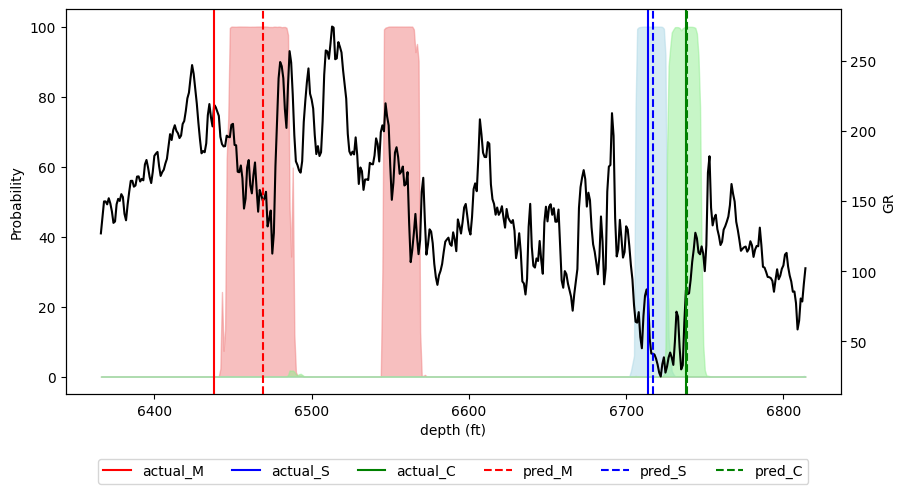

In [21]:
wsize = 201 #adjust as needed
well = 512327050	
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvain', 'Conrad']

intervals = apply_process(df_tops,confidence_level=0.96)
pred_m, df_wm = get_markers_rocket_order_with_constraint(well,f_mean, f_std,intervals, df_test_log, pred_column, wsize, input_variable, 
                                             s2s = True,
                                             model = model, 
                                             xgb = False,
                                             rocket = None, 
                                             classifier_xgb = None, 
                                             classifier = None,
                                             constraint = True,)

td  = list(df_test_tops.loc[[well][0]]) 
print(f'Prediction:{pred_m}')
print(f'Real:{td}')
plot_pred_distribution(td, pred_m, df_wm)
                                    

MARCEL 6212.0 6764.0
SYLVAIN 6441.0 7010.0
CONRAD 6464.0 7033.0
Prediction:[6469, 6717, 6739]
Real:[6438.0, 6714.0, 6738.0]


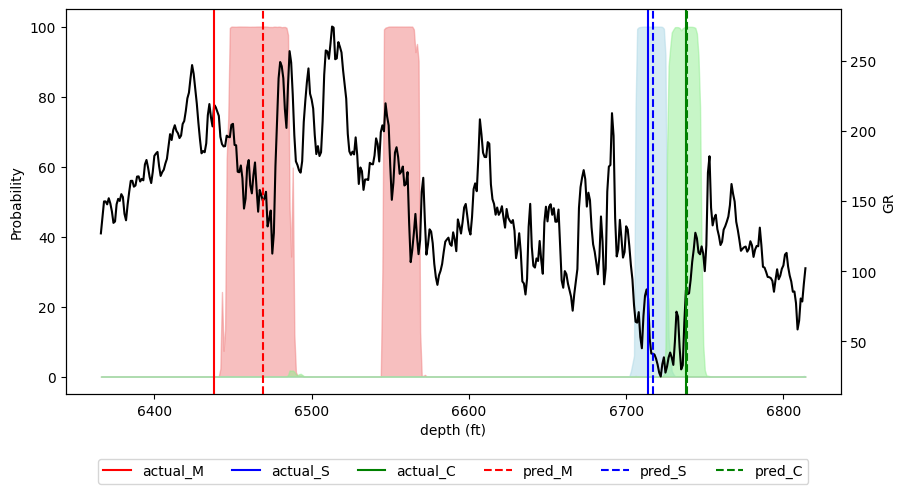

In [22]:
wsize = 201 #adjust as needed
well = 512327050	
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvain', 'Conrad']

intervals = apply_process(df_tops,confidence_level=0.01)
pred_m, df_wm = get_markers_rocket_order_with_constraint(well,f_mean, f_std,intervals, df_test_log, pred_column, wsize, input_variable, 
                                             s2s = True,
                                             model = model, 
                                             xgb = False,
                                             rocket = None, 
                                             classifier_xgb = None, 
                                             classifier = None,
                                             constraint = False,)

td  = list(df_test_tops.loc[[well][0]]) 
print(f'Prediction:{pred_m}')
print(f'Real:{td}')
plot_pred_distribution(td, pred_m, df_wm)
                                    